<a href="https://colab.research.google.com/github/Codeblockz/Data-Science-Self-Projects/blob/main/Kaggle_Titanic_challege/Titanic_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Titanic Challenge Kaggle <br></br>
[source 1](https://triangleinequality.wordpress.com/2013/09/08/basic-feature-engineering-with-the-titanic-data/)  <br></br>
[source 2]( https://www.kaggle.com/lonnieqin/classification-with-sklearn-and-tensorflow)

## Download Data

In [117]:
# from google.colab import files
# from os.path import exists
# file_exists = exists("/content/kaggle.json")
# if (file_exists==False):
#   files.upload()

In [118]:
%cd /content/drive/MyDrive/Colab Notebooks/Titanic

/content/drive/MyDrive/Colab Notebooks/Titanic


In [119]:
! pip install -q kaggle
!pip install --upgrade kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [120]:
 ! kaggle competitions download titanic

train.csv: Skipping, found more recently modified local copy (use --force to force download)
test.csv: Skipping, found more recently modified local copy (use --force to force download)
gender_submission.csv: Skipping, found more recently modified local copy (use --force to force download)


Start To work on geting data

In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
import tensorflow as tf
from tensorflow import feature_column
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import model_selection
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import string
import copy
from sklearn import preprocessing

In [122]:
# Load Data
train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Titanic/train.csv")
test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Titanic/test.csv")
train1 = copy.copy(train)
test1 = copy.copy(test)
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Check For Nulls


In [123]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [124]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

Check Data Types

In [125]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [126]:
test.dtypes

PassengerId      int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

# Data Scrubing 

## Replace NaN

In [127]:
# from source 2
# Replace NAN
# embark_label = train["Embarked"].mode()[0]
# train["Cabin"] = train["Cabin"].replace(np.NAN,  "Unknown")
# train["Embarked"] = train["Embarked"].replace(np.NAN, embark_label)
# train["Age"] = train["Age"].replace(np.NAN, train["Age"].mean())

# # Test Replace
# test["Cabin"] = test["Cabin"].replace(np.NAN, "Unknown")
# test["Age"] = test["Age"].replace(np.NAN, test["Age"].mean())
# test["Fare"] = test["Fare"].replace(np.NAN, test["Fare"].mean())

In [128]:
def get_replaced_nan(data):
  embark_label = data["Embarked"].mode()[0]
  data["Cabin"] = data["Cabin"].replace(np.NAN,  "Unknown")
  data["Embarked"] = data["Embarked"].replace(np.NAN, embark_label)
  data["Age"] = data["Age"].replace(np.NAN, data["Age"].mean())
  data["Fare"] = data["Fare"].replace(np.NAN, data["Fare"].mean())
  return data

## Make Title Column

In [129]:
# source 1
def substrings_in_string(big_string, substrings):
    for substring in substrings:
        if big_string.find(substring) != -1:
            return substring
    # print(big_string) # For debug check
    return np.nan

In [130]:
#replacing all titles with mr, mrs, miss, master
def replace_titles(x):
    title=x['Title']
    if title in ['Don', 'Major', 'Capt', 'Jonkheer', 'Rev', 'Col']:
        return 'Mr'
    elif title in ['Countess', 'Mme']:
        return 'Mrs'
    elif title in ['Mlle', 'Ms']:
        return 'Miss'
    elif title =='Dr':
        if x['Sex']=='Male':
            return 'Mr'
        else:
            return 'Mrs'
    else:
        return title

In [131]:
# Apply function to data
# title_list=['Mrs', 'Mr', 'Master', 'Miss', 'Major', 'Rev', 'Dr', 'Ms', 'Mlle',
#             'Col', 'Capt', 'Mme', 'Countess', 'Don', 'Jonkheer']
# train['Title']=train['Name'].map(lambda x: substrings_in_string(x, title_list))
# test['Title'] = train['Name'].map(lambda x: substrings_in_string(x, title_list))
# train['Title']=train.apply(replace_titles, axis=1)
# test['Title']=test.apply(replace_titles, axis=1)

In [132]:
def get_titles(data):
  title_list=['Mrs', 'Mr', 'Master', 'Miss', 'Major', 'Rev', 'Dr', 'Ms', 'Mlle',
            'Col', 'Capt', 'Mme', 'Countess', 'Don', 'Jonkheer']
  data['Title']=data['Name'].map(lambda x: substrings_in_string(x, title_list))
  data['Title']=data.apply(replace_titles, axis=1)
  return data

In [133]:
# data check
#train.head()
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

## Make Cabin Type

In [134]:
# Make cabin type
# Source 2
# train['Cabin_type'] = train["Cabin"].apply(lambda cabin: cabin[0])
# test["Cabin_type"] = test["Cabin"].apply(lambda cabin: cabin[0])
# # Make New feature
# train["family_member_size"] = 1 + train["SibSp"] + train["Parch"]
# test["family_member_size"] = 1 + test["SibSp"] + test["Parch"]

In [135]:
# data check
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [136]:
# data check 
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## Make Family Size Type

The correlation bellow shows that Family size is not linearly related however there is a relationship between survival and family size

In [137]:
def convert_faimly_member_size(size):
    if size == 1:
        return "single"
    elif size < 5:
        return "medium"
    else:
        return "large"

In [138]:
# should_add_family_member_type = True
# if should_add_family_member_type:
#     for data in [train, test]:
#         data["family_member_type"] = train["family_member_size"].apply(convert_faimly_member_size)

## Make Encoders

In [139]:
#encode_vals = ['Sex','Cabin_type','Embarked','Title','family_member_type']
VAL = ['Sex','Cabin_type','Embarked','Title','family_member_type']

In [140]:
# make non one hot encoded values
def make_encode_num(data):
  #val = ['Sex','Cabin_type','Embarked','Title','family_member_type']
  for feature in VAL:
    if feature in data.columns:
      data[feature]=data[feature].astype('category')
      data[feature+'_value']=np.int64(data[feature].cat.codes)
  return data
# train=make_encode_num(train)
# test = make_encode_num(test)

In [141]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [142]:
# make one hot encoding
# originally named one_hot_tit()
# I only relized after I made the function how bad the naming was
def one_hot(data, original_feature=False):
  for feature in VAL:
    if feature in data.columns:
      temp = data[feature]
      data= pd.get_dummies(data, columns=[feature], dtype=int)
      data.pop(feature+'_value')
      if original_feature == True :
        data[feature]=temp
  return data

## More Functions

### Get_Data

In [143]:
def get_data(data, should_add_family_member_type=False):
  # Replace NaNs
  data = get_replaced_nan(data)
  # get titles
  data = get_titles(data)
  # Get Cabin type
  data['Cabin_type'] = data["Cabin"].apply(lambda cabin: cabin[0])
  # Make New feature
  data["family_member_size"] = 1 + data["SibSp"] + data["Parch"]
  # Family memeber
  if should_add_family_member_type:
    data["family_member_type"] = data["family_member_size"].apply(convert_faimly_member_size)
  # encode
  data = make_encode_num(data)
  return data

### CleanUp

In [144]:
# make clean up
# Assumes all data in column is same type
# For numeric data
def cleanUp(data):
  for i in data.columns:
    #print(data[i])
    if isinstance(data[i].iloc[0],(np.float, np.integer))==False:
      # print(i)
      data.pop(i)
  data.pop("PassengerId")
  return data 

### getTuple

In [145]:
# number reshape
def getTuple(Value):
  x, y = Value.shape
  z=1
  t = (x,y,z)
  return t 

### get_train_test

In [146]:
def get_train_test(data, isCC = False, isValUsed = False):
  X = data.drop("Survived", axis=1)
  y = data["Survived"]
  #print("X shape: ", X.shape)
  #print(X.values.reshape(891, 27,1))
  X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
  if isValUsed== True and isCC == True:
    X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42)
    X_test = X_test.values
    y_test = y_test.values
    X_test=np.expand_dims(X_test,axis=2)
    #print("isvaluUsed = True and isCC= true")
  elif isValUsed==True and isCC == False:
    X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42)
    #print("isvalue = true and isCC false")
  else:
    #print("isvalue false isCC false")
    X_test = 0
    y_test = 0 
  if isCC==True:
    X_train=X_train.values
    y_train= y_train.values
    X_val= X_val.values
    y_val=y_val.values
    X_train=np.expand_dims(X_train,axis=2)
    X_val=np.expand_dims(X_val,axis=2)
  return (X_train, X_val, X_test, y_train, y_val, y_test)

In [147]:
def get_train_test(data, isCC = False, isValUsed = False):
  X = data.drop("Survived", axis=1)
  y = data["Survived"]
  #print("X shape: ", X.shape)
  #print(X.values.reshape(891, 27,1))
  X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
  if isCC==True:
    X_train=X_train.values
    y_train= y_train.values
    X_val= X_val.values
    y_val=y_val.values
    X_train=np.expand_dims(X_train,axis=2)
    X_val=np.expand_dims(X_val,axis=2)
  if isValUsed:
    X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42)
    #print(X_test.shape)
  else: 
    X_test = 0
    y_test = 0
  return (X_train, X_val, X_test, y_train, y_val, y_test)

### make_tensor

In [148]:
# def make_tensor(data):
#   X_train, X_val, X_test, y_train, y_val, y_test = get_train_test= get_train_test(data)
#   print("X_train shape: ", X_train.shape)
#   print("X_train Type: ", type(X_train))
#   print("y_train: ",y_train.shape)
#   train_tensor = tf.data.Dataset.from_tensor_slices((X_train.values, y_train.values))
#   val_tensor = tf.data.Dataset.from_tensor_slices((X_val.values, y_val.values))
#   return train_tensor, val_tensor

In [149]:
# # Testing
# ##################################
# X = copy.copy(OH_train)
# X = X.drop("Survived", axis=1)
# #print("X shape: ", X.shape)
# xshap = X.shape
# x, y = X.shape
# t = (x,y,1)
# #print(t)
# OH_tt, OH_tv = make_tensor(OH_train)
# OH_tt.element_spec

## Apply Functions

### Manual Data Scrub and Format

In [150]:
embark_label = train["Embarked"].mode()[0]
train["Cabin"] = train["Cabin"].replace(np.NAN,  "Unknown")
train["Embarked"] = train["Embarked"].replace(np.NAN, embark_label)
train["Age"] = train["Age"].replace(np.NAN, train["Age"].mean())
# Test Replace
test["Cabin"] = test["Cabin"].replace(np.NAN, "Unknown")
test["Age"] = test["Age"].replace(np.NAN, test["Age"].mean())
test["Fare"] = test["Fare"].replace(np.NAN, test["Fare"].mean())
# Make Titles
title_list=['Mrs', 'Mr', 'Master', 'Miss', 'Major', 'Rev', 'Dr', 'Ms', 'Mlle',
            'Col', 'Capt', 'Mme', 'Countess', 'Don', 'Jonkheer']
train['Title']=train['Name'].map(lambda x: substrings_in_string(x, title_list))
test['Title'] = train['Name'].map(lambda x: substrings_in_string(x, title_list))
train['Title']=train.apply(replace_titles, axis=1)
test['Title']=test.apply(replace_titles, axis=1)
# Make Cabin Type
train['Cabin_type'] = train["Cabin"].apply(lambda cabin: cabin[0])
test["Cabin_type"] = test["Cabin"].apply(lambda cabin: cabin[0])
# Family Size
train["family_member_size"] = 1 + train["SibSp"] + train["Parch"]
test["family_member_size"] = 1 + test["SibSp"] + test["Parch"]
# family size type
should_add_family_member_type = True
if should_add_family_member_type:
    for data in [train, test]:
        data["family_member_type"] = train["family_member_size"].apply(convert_faimly_member_size)
# regular encode
train = make_encode_num(train)
test = make_encode_num(test)

### Express Data Scrub and Format

In [151]:
# For Simplicity
train_test = pd.concat([train1,test1])
train_test = get_data(train_test, True)
train = train_test.iloc[0:len(train)]
test = train_test.iloc[len(train):]

### One Hot encode Data
- Prepare data for models <br>
- OH stands for one hot <br>
- EN stands for encoded, not one hot, it is Label encoding <br>
- Use concat to save time

In [152]:
OH_train_test = pd.concat([train,test])
EN_train_test = pd.concat([train, test])
# print shape and size for latter
print("Train Shape: ",train.shape)
print("Train Size: ", len(train))

Train Shape:  (891, 21)
Train Size:  891


In [153]:
# apply OH
# remember to apply with and without family type and size
OH_train_test=one_hot(OH_train_test, False)
OH_train_test = cleanUp(OH_train_test)
OH_train_test["Survived"] = OH_train_test["Survived"].replace(np.NAN, np.int(1))
# Apply EN
EN_train_test = cleanUp(EN_train_test)
EN_train_test["Survived"] = EN_train_test["Survived"].replace(np.NAN, np.int(1))

In [154]:
# Testing
##########################################
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
# pd.set_option('display.width',None)
# pd.set_option('display.max_colwidth', -1)
# pd.reset_option("^display")
# OH_train_test#

In [155]:
OH_train_test.dtypes

Survived                     float64
Pclass                         int64
Age                          float64
SibSp                          int64
Parch                          int64
Fare                         float64
family_member_size             int64
Sex_female                     int64
Sex_male                       int64
Cabin_type_A                   int64
Cabin_type_B                   int64
Cabin_type_C                   int64
Cabin_type_D                   int64
Cabin_type_E                   int64
Cabin_type_F                   int64
Cabin_type_G                   int64
Cabin_type_T                   int64
Cabin_type_U                   int64
Embarked_C                     int64
Embarked_Q                     int64
Embarked_S                     int64
Title_Master                   int64
Title_Miss                     int64
Title_Mr                       int64
Title_Mrs                      int64
family_member_type_large       int64
family_member_type_medium      int64
f

### Normalization 

In [156]:
# Scaling
min_max_scaler = preprocessing.MinMaxScaler()
OH_scaled = min_max_scaler.fit_transform(OH_train_test)
EN_scaled = min_max_scaler.fit_transform(EN_train_test)
OH_train_test = pd.DataFrame(OH_scaled, columns=OH_train_test.columns)
EN_train_test = pd.DataFrame(EN_scaled, columns=EN_train_test.columns)

In [157]:
# train and test
EN_train = EN_train_test.iloc[0:len(train)]
OH_train = OH_train_test.iloc[0:len(train)]
EN_test = EN_train_test.iloc[len(train):]
OH_test = OH_train_test.iloc[len(train):]
EN_test = EN_test.drop("Survived", axis=1)
OH_test = OH_test.drop("Survived", axis=1)

In [158]:
# data check
OH_train_test.head()
# OH_train.shape
# OH_tt.element_spec
EN_test

,Pclass,Age,SibSp,Parch,Fare,family_member_size,Sex_value,Cabin_type_value,Embarked_value,Title_value,family_member_type_value
891,1.0,0.430039,0.000,0.000000,0.015282,0.0,1.0,1.00,0.5,0.666667,1.0
892,1.0,0.586622,0.125,0.000000,0.013663,0.1,0.0,1.00,1.0,1.000000,0.5
893,0.5,0.774521,0.000,0.000000,0.018909,0.0,1.0,1.00,0.5,0.666667,1.0
894,1.0,0.336089,0.000,0.000000,0.016908,0.0,1.0,1.00,1.0,0.666667,1.0
895,1.0,0.273456,0.125,0.111111,0.023984,0.2,0.0,1.00,1.0,1.000000,0.5
...,...,...,...,...,...,...,...,...,...,...,...
1304,1.0,0.372180,0.000,0.000000,0.015713,0.0,1.0,1.00,1.0,0.666667,1.0
1305,0.0,0.486409,0.000,0.000000,0.212559,0.0,0.0,0.25,0.0,0.666667,1.0
1306,1.0,0.480145,0.000,0.000000,0.014151,0.0,1.0,1.00,1.0,0.666667,1.0
1307,1.0,0.372180,0.000,0.000000,0.015713,0.0,1.0,1.00,1.0,0.666667,1.0


In [159]:
# data check
test.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Cabin_type,family_member_size,family_member_type,Sex_value,Cabin_type_value,Embarked_value,Title_value,family_member_type_value
0,892,NaN,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,Unknown,Q,Mr,U,1,single,1,8,1,2,2
1,893,NaN,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,Unknown,S,Mrs,U,2,medium,0,8,2,3,1
2,894,NaN,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,Unknown,Q,Mr,U,1,single,1,8,1,2,2
3,895,NaN,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,Unknown,S,Mr,U,1,single,1,8,2,2,2
4,896,NaN,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,Unknown,S,Mrs,U,3,medium,0,8,2,3,1


In [160]:
#temp.corr()["Survived"].sort_values(key=lambda x: abs(x), ascending=False)

# Exploratory Data Analysis For Survival

In [161]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   PassengerId               891 non-null    int64   
 1   Survived                  891 non-null    float64 
 2   Pclass                    891 non-null    int64   
 3   Name                      891 non-null    object  
 4   Sex                       891 non-null    category
 5   Age                       891 non-null    float64 
 6   SibSp                     891 non-null    int64   
 7   Parch                     891 non-null    int64   
 8   Ticket                    891 non-null    object  
 9   Fare                      891 non-null    float64 
 10  Cabin                     891 non-null    object  
 11  Embarked                  891 non-null    category
 12  Title                     891 non-null    category
 13  Cabin_type                891 non-null    category

In [162]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,family_member_size,Sex_value,Cabin_type_value,Embarked_value,Title_value,family_member_type_value
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.735277,0.523008,0.381594,32.204208,1.904602,0.647587,6.716049,1.536476,1.860831,1.533109
std,257.353842,0.486592,0.836071,13.002218,1.102743,0.806057,49.693429,1.613459,0.477990,2.460739,0.791503,0.721066,0.623305
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400,1.000000,0.000000,8.000000,1.000000,2.000000,1.000000
50%,446.000000,0.000000,3.000000,29.881138,0.000000,0.000000,14.454200,1.000000,1.000000,8.000000,2.000000,2.000000,2.000000
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000,2.000000,1.000000,8.000000,2.000000,2.000000,2.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,11.000000,1.000000,8.000000,2.000000,3.000000,2.000000


## Survival by Cabin Type

In [163]:
train.groupby("Cabin_type")["Survived"].mean()

Cabin_type
A    0.466667
B    0.744681
C    0.593220
D    0.757576
E    0.750000
F    0.615385
G    0.500000
T    0.000000
U    0.299854
Name: Survived, dtype: float64

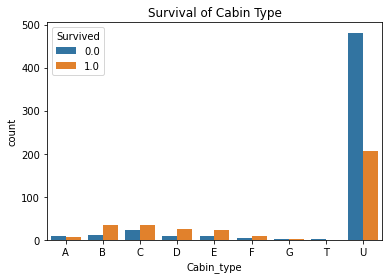

In [164]:
sns.countplot(x="Cabin_type",hue="Survived", data=train)
plt.title("Survival of Cabin Type")
plt.show()

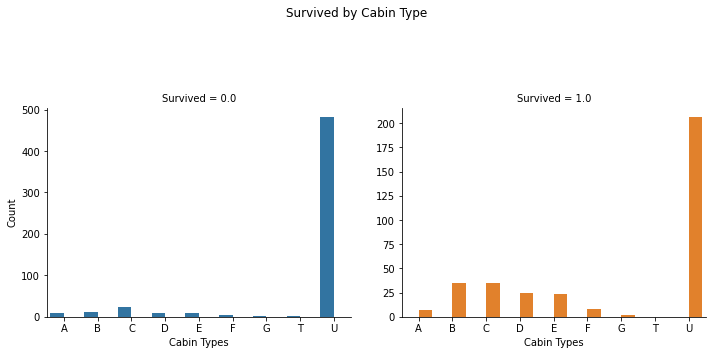

In [165]:
cabin_type_plot= sns.catplot(x="Cabin_type", hue="Survived", col="Survived", data=train, kind="count", sharey=False)
cabin_type_plot.fig.subplots_adjust(top=0.7)
cabin_type_plot.fig.suptitle("Survived by Cabin Type")
cabin_type_plot.set_xlabels("Cabin Types")
cabin_type_plot.set_ylabels("Count")
plt.show()

## Survival by Pclass

In [166]:
train.groupby("Pclass")["Survived"].mean()

Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64

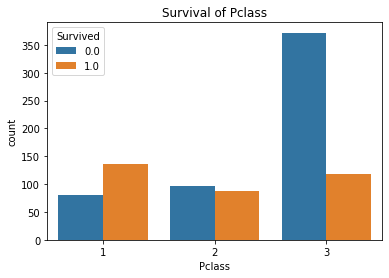

In [167]:
sns.countplot(x="Pclass",hue="Survived", data=train)
plt.title("Survival of Pclass")
plt.show()

## Survival by Sex

In [168]:
train.groupby("Pclass")["Survived"].mean()

Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64

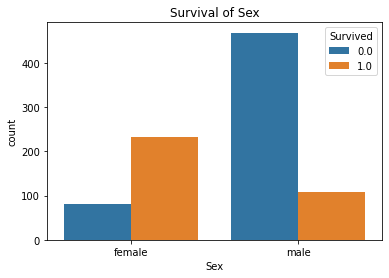

In [169]:
sns.countplot(x="Sex",hue="Survived", data=train)
plt.title("Survival of Sex")
plt.show()

## Survival by Age

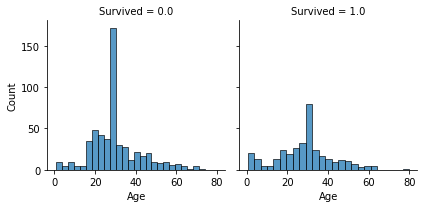

In [170]:
sns.FacetGrid(train, col="Survived").map(sns.histplot, "Age", bins=25)
plt.show()

## Survial by Sibsp

In [171]:
train.groupby("SibSp")["Survived"].mean()

SibSp
0    0.345395
1    0.535885
2    0.464286
3    0.250000
4    0.166667
5    0.000000
8    0.000000
Name: Survived, dtype: float64

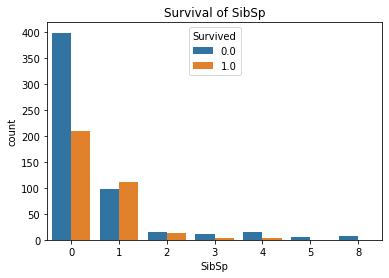

In [172]:
sns.countplot(x="SibSp",hue="Survived", data=train)
plt.title("Survival of SibSp")
plt.show()

## Survival by Parch

In [173]:
train.groupby("Parch")["Survived"].mean()

Parch
0    0.343658
1    0.550847
2    0.500000
3    0.600000
4    0.000000
5    0.200000
6    0.000000
Name: Survived, dtype: float64

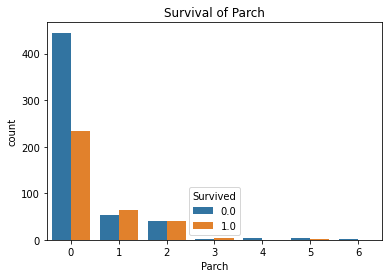

In [174]:
sns.countplot(x="Parch",hue="Survived", data=train)
plt.title("Survival of Parch")
plt.show()


## Survival by Fare


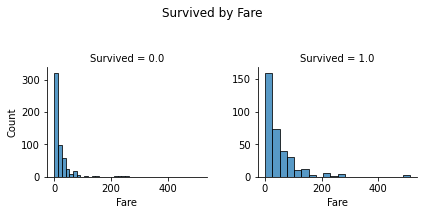

In [175]:
Fare_plot=sns.FacetGrid(train, col="Survived", sharey=False)
Fare_plot.map(sns.histplot, "Fare",bins=20)
Fare_plot.fig.subplots_adjust(top=0.7)
Fare_plot.fig.suptitle("Survived by Fare")
Fare_plot.set_xlabels("Fare")
Fare_plot.set_ylabels("Count")
plt.show()

## Survival by Embarked


In [176]:
train.groupby("Embarked")["Survived"].mean()

Embarked
C    0.553571
Q    0.389610
S    0.339009
Name: Survived, dtype: float64

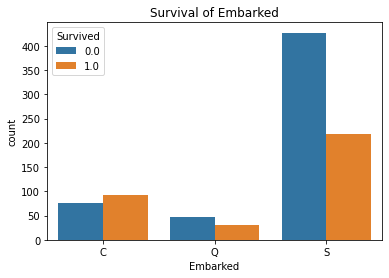

In [177]:
sns.countplot(x="Embarked",hue="Survived",data=train)
plt.title("Survival of Embarked")
plt.show()

## Survived by Title

In [178]:
train.groupby("Title")["Survived"].mean()

Title
Master    0.575000
Miss      0.703297
Mr        0.158192
Mrs       0.775362
Name: Survived, dtype: float64

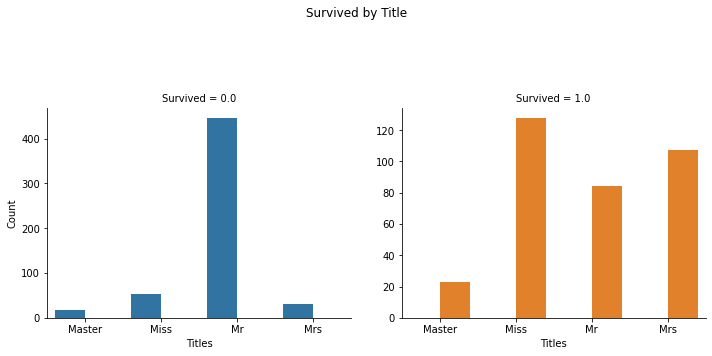

In [179]:
title_plot= sns.catplot(x="Title", hue="Survived", col="Survived", data=train, kind="count", sharey=False)
title_plot.fig.subplots_adjust(top=0.7)
title_plot.fig.suptitle("Survived by Title")
title_plot.set_xlabels("Titles")
title_plot.set_ylabels("Count")
plt.show()

In [180]:
train.max()

PassengerId                                         891
Survived                                              1
Pclass                                                3
Name                        van Melkebeke, Mr. Philemon
Age                                                  80
SibSp                                                 8
Parch                                                 6
Ticket                                        WE/P 5735
Fare                                            512.329
Cabin                                           Unknown
family_member_size                                   11
Sex_value                                             1
Cabin_type_value                                      8
Embarked_value                                        2
Title_value                                           3
family_member_type_value                              2
dtype: object

## Survival Factors

In [181]:
# source 2
train.corr()["Survived"].sort_values(key=lambda x: abs(x), ascending=False)

Survived                    1.000000
Sex_value                  -0.543351
Pclass                     -0.338481
Cabin_type_value           -0.301116
Fare                        0.257307
Embarked_value             -0.167675
family_member_type_value   -0.108631
Parch                       0.081629
Age                        -0.070323
Title_value                -0.062139
SibSp                      -0.035322
family_member_size          0.016639
PassengerId                -0.005007
Name: Survived, dtype: float64

In [182]:
# See what .index Does
# index gives the feature values that equaled true
###########################################################
# k = train.corr()[train.corr()["Survived"].abs()>.05]
# l=list(train.corr()[train.corr()["Survived"].abs()>.05] )
# p=list(train.corr()[train.corr()["Survived"].abs()>.05].index )
# print(len(l),"\n",l)
# print(len(p),"\n",p)
# res = [x for x in l + p if x not in l or x not in p]
# print(res)
# print(k)

In [183]:
# Source 2
related_columns = list(train.corr()[train.corr()["Survived"].abs() > 0.05].index)
related_columns.remove("Survived")
print(related_columns)

['Pclass', 'Age', 'Parch', 'Fare', 'Sex_value', 'Cabin_type_value', 'Embarked_value', 'Title_value', 'family_member_type_value']


# Models

In [184]:
Models = dict()
Model_acc = dict()

In [185]:
# Models['OH_CNN_model']=[OH_CNN_model,OH_acc_CNN[1]]
# Models['EN_CNN_model']=[EN_CNN_model, EN_acc_CNN[1]]

## DNN Models

### CNN Model

In [186]:
## testing
# X_train, X_val, X_test, y_train, y_val, y_test = get_train_test(OH_train, True)
# # X_train=X_train.values
# # y_train= y_train.values
# # X_val= X_val.values
# # y_val=y_val.values
# # X_train=np.expand_dims(X_train,axis=2)
# # X_val=np.expand_dims(X_val,axis=2)
# X_train, X_val, X_test, y_train, y_val, y_test = get_train_test(EN_train, True)
# print("X_val.shape: ",X_val.shape)
# print("y_val.shape: ",y_val.shape)
# print("X_train.shape: ",X_train.shape)
# print("y_train.shape: ",y_train.shape)

#### CNN Make Model

In [187]:
def makeCN_Model(input_shape):
  model = tf.keras.Sequential([
  #tf.keras.layers.Input(27,1),
  tf.keras.layers.Conv1D(128, 2, activation='relu',input_shape=input_shape),
  tf.keras.layers.MaxPooling1D(pool_size=2),
  tf.keras.layers.Conv1D(128, 4, activation='relu'),
  tf.keras.layers.MaxPooling1D(pool_size=2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(100, activation="relu"),
  tf.keras.layers.Dense(1, activation='sigmoid')
  ])
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  return model
#model.summary()

#### CNN Get Trained Model

In [188]:
def get_trained_CNN_model(Data, isValUsed = True):
  X_train, X_val, X_test, y_train, y_val, y_test = get_train_test(Data, True, isValUsed)
  # X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42)
  x, y, z = X_train.shape
  model = makeCN_Model((y,z))
  early_stop = tf.keras.callbacks.EarlyStopping(patience=10, monitor='accuracy')
  if isValUsed:
    model.fit(X_train, y_train,epochs=4000, 
      validation_data=(X_val,y_val), 
      callbacks=[early_stop],
      verbose=0)
  else:
    model.fit(X_train, y_train,epochs=4000, 
      #validation_data=(X_val,y_val), 
      callbacks=[early_stop],
      verbose=0)
  #acc_ofmodel = model.evaluate(X_val, y_val, verbose=0)
  #print("Accuracy:",acc_ofmodel[1])
  return model #, X_test, y_test 

#### Apply CNN and Get Plots

In [189]:
# for OH
X_train, X_val, X_test, y_train, y_val, y_test = get_train_test(OH_train, True, True)
x, y, z = X_train.shape
print("X_val.shape: ",X_val.shape)
print("y_val.shape: ",y_val.shape)
print("X_train.shape: ",X_train.shape)
print("y_train.shape: ",y_train.shape)
input_shape = (y,z)
print("input Shape:",input_shape)
OH_CNN_model=makeCN_Model((y,z))
# OH_CNN_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
OH_CNN_model.summary()

X_val.shape:  (89, 27, 1)
y_val.shape:  (89,)
X_train.shape:  (712, 27, 1)
y_train.shape:  (712,)
input Shape: (27, 1)
Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_12 (Conv1D)           (None, 26, 128)           384       
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 13, 128)           0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 10, 128)           65664     
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, 5, 128)            0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 640)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 100)               64100     


Accuracy:  0.8111110925674438


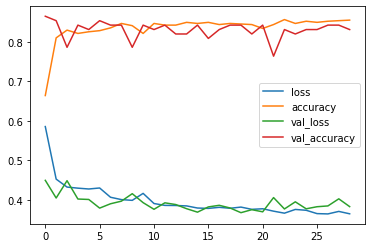

In [190]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=10)
history = OH_CNN_model.fit(
    X_train, y_train,epochs=400, 
    validation_data=(X_val,y_val), 
    callbacks=[early_stop],
    verbose=0
)
pd.DataFrame(history.history).plot()
acc_ofmodel = OH_CNN_model.evaluate(X_test,y_test, verbose=0)
print("Accuracy: ",acc_ofmodel[1])

In [191]:
OH_acc_CNN = OH_CNN_model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: ",OH_acc_CNN[1])
Models['OH_CNN_model']=[OH_CNN_model,OH_acc_CNN[1]]

Accuracy:  0.8111110925674438


For testing purposes

In [192]:
data = OH_train
X_train, X_val, X_test, y_train, y_val, y_test = get_train_test(data, True, True)
ohVal = get_trained_CNN_model(data, isValUsed = True)
print("Acc w/ val:",ohVal.evaluate(X_test, y_test))
X_train, X_val, X_test, y_train, y_val, y_test = get_train_test(data, True, False)
ohNoVal = get_trained_CNN_model(data, isValUsed = False)
print("Acc w/o val:",ohVal.evaluate(X_val, y_val))

3/3 [==============================] - 0s 4ms/step - loss: 0.5118 - accuracy: 0.8111
Acc w/ val: [0.5117717981338501, 0.8111110925674438]
6/6 [==============================] - 0s 4ms/step - loss: 0.4488 - accuracy: 0.8156
Acc w/o val: [0.4487753212451935, 0.8156424760818481]


In [193]:
# datasets = {
#   "EN cor dataset":dataset0,
#   "OH cor dataset":dataset1,
#   "OH dataset":dataset2, 
#   "EN dataset":dataset3
# }
# sets = "OH dataset"
# X_train, X_val, X_test, y_train, y_val, y_test = get_train_test(datasets[sets])
# model = get_trained_DNN_model(datasets[sets])
# model.evaluate(X_test, y_test)

In [194]:
# For EN
X_train, X_val, X_test, y_train, y_val, y_test = get_train_test(EN_train, True, True)
x, y, z = X_train.shape
print("X_val.shape: ",X_val.shape)
print("y_val.shape: ",y_val.shape)
print("X_train.shape: ",X_train.shape)
print("y_train.shape: ",y_train.shape)
input_shape = (y,z)
# print(input_shape)
EN_CNN_model=makeCN_Model((y,z))
# EN_CNN_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
EN_CNN_model.summary()

X_val.shape:  (89, 11, 1)
y_val.shape:  (89,)
X_train.shape:  (712, 11, 1)
y_train.shape:  (712,)
Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_18 (Conv1D)           (None, 10, 128)           384       
_________________________________________________________________
max_pooling1d_18 (MaxPooling (None, 5, 128)            0         
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 2, 128)            65664     
_________________________________________________________________
max_pooling1d_19 (MaxPooling (None, 1, 128)            0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 100)               12900     
_____________________

Accuracy:  0.7777777910232544


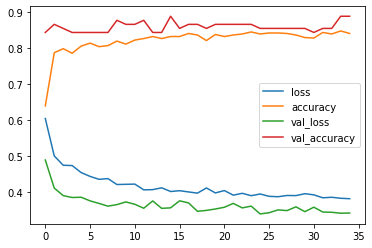

In [195]:
history = EN_CNN_model.fit(
    X_train, y_train,epochs=4000, 
    validation_data=(X_val,y_val), 
    callbacks=[early_stop],
    verbose=0
)
pd.DataFrame(history.history).plot()
acc_ofmodel = EN_CNN_model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: ",acc_ofmodel[1])

In [196]:
# For Comparison 
EN_acc_CNN = EN_CNN_model.evaluate(X_test, y_test, verbose=0)
print(EN_acc_CNN)
Models['EN_CNN_model']=[EN_CNN_model, EN_acc_CNN[1]]

[0.5053181052207947, 0.7777777910232544]


In [197]:
# model = get_trained_DNN_model(dataset0)

### DNN Model

#### Fit DNN Model

In [198]:
def fit_DNN_Model(model, epochs=400):
  history = model.fit(
    X_train, y_train,epochs=epochs, 
    validation_data=(X_val,y_val), 
    callbacks=[early_stop],
    verbose=0
  )
  pd.DataFrame(history.history).plot()
  acc_ofmodel = model.evaluate(X_test, y_test, verbose=0)
  print("Accuracy: ",acc_ofmodel[1])
  return acc_ofmodel[1]

#### Make DNN Model

In [199]:
def DNN_model(input_dim):
   model = tf.keras.Sequential([
      tf.keras.layers.Input(shape=(input_dim)),
      tf.keras.layers.Dense(1000, activation='relu', name = "L1"), 
      tf.keras.layers.Dense(750, activation='relu', name = "L2"),  
      tf.keras.layers.Dense(500, activation='relu', name = "L3"),  
      tf.keras.layers.Dense(250, activation='relu', name = "L4"),  
      tf.keras.layers.Dense(50, activation='relu', name ="L5"),
      tf.keras.layers.Dense(1, activation='sigmoid', name ="L6")                          
   ])
   model.NAME = "model1"
   model._estimator_type = "classifier" # debug for stackin
   model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
   return model

#### DNN Get Trained Model

In [200]:
def get_trained_DNN_model(Data, isValUsed = True):
  X_train, X_val, X_test, y_train, y_val, y_test = get_train_test(Data, False, isValUsed)
  # X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42)
  model = DNN_model(X_train.shape[1])
  early_stop = tf.keras.callbacks.EarlyStopping(patience=10)
  if isValUsed:
    model.fit(
      X_train, y_train,epochs=epochs, 
      validation_data=(X_val,y_val), 
      callbacks=[early_stop],
      verbose=0
    )
  else:
     model.fit(
      X_train, y_train,epochs=epochs, 
      #validation_data=(X_val,y_val), 
      callbacks=[early_stop],
      verbose=0
    )
  acc_ofmodel = model.evaluate(X_val, y_val, verbose=0)
  #print("Accuracy:",acc_ofmodel[1])
  return model #, X_test, y_test

#### Fit and Plot Model

27
Accuracy:  0.7888888716697693


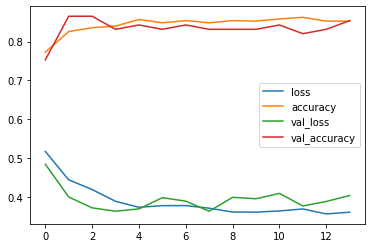

In [201]:
X_train, X_val, X_test, y_train, y_val, y_test = get_train_test(OH_train, False, True)
print(X_train.shape[1])
OH_DNN_model = DNN_model(X_train.shape[1])
OH_acc_DNN = fit_DNN_Model(OH_DNN_model)
Models['OH_DNN_model']=[OH_DNN_model,OH_acc_DNN]

In [202]:
OH_DNN_model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
L1 (Dense)                   (None, 1000)              28000     
_________________________________________________________________
L2 (Dense)                   (None, 750)               750750    
_________________________________________________________________
L3 (Dense)                   (None, 500)               375500    
_________________________________________________________________
L4 (Dense)                   (None, 250)               125250    
_________________________________________________________________
L5 (Dense)                   (None, 50)                12550     
_________________________________________________________________
L6 (Dense)                   (None, 1)                 51        
Total params: 1,292,101
Trainable params: 1,292,101
Non-trainable params: 0
___________________________________________

Accuracy:  0.7777777910232544


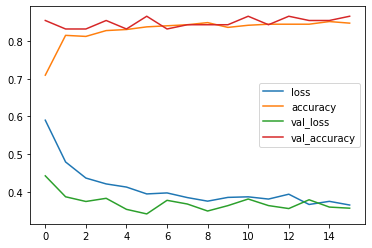

In [203]:
X_train, X_val, X_test, y_train, y_val, y_test = get_train_test(EN_train, False, True)
EN_DNN_model = DNN_model(X_train.shape[1])
EN_acc_DNN = fit_DNN_Model(EN_DNN_model)
Models['EN_DNN_model']=[EN_DNN_model,EN_acc_DNN]

In [204]:
# X_train, X_val, X_test, y_train, y_val, y_test = get_train_test(EN_train, False, True)
# Models['EN_DNN_model'][0].evaluate(X_val, y_val, verbose=0)

### Deep and Wide Model

In [205]:
categorical_feature_names = ["Pclass", "Sex_value", "Embarked_value", "Cabin_type_value"]
numerical_feature_names = ["Age", "Fare", "SibSp", "Parch", "family_member_size"]
categorical_features = [
    feature_column.indicator_column(
        feature_column.categorical_column_with_vocabulary_list(key, sorted(list(train[key].unique())))
    ) for key in categorical_feature_names
]
# print(categorical_features)
numerical_features = [feature_column.numeric_column(key) for key in numerical_feature_names]
input_dictionary = dict()
inputs = dict()
for item in numerical_features:
    inputs[item.key] = tf.keras.layers.Input(name=item.key, shape=())
for item in categorical_features:
    #print(item.categorical_column.key)
    inputs[item.categorical_column.key] = tf.keras.layers.Input(name=item.categorical_column.key, shape=(), dtype="int32")

In [206]:
# Source 2 
# Helper Features
def features_and_labels(row_data):
    label = row_data.pop("Survived")
    features = row_data
    # print("Label: ", label)
    # print("Feature: ", features)
    return features, label

def create_dataset(pattern, epochs=1, batch_size=32, mode='eval'):
    dataset = tf.data.experimental.make_csv_dataset(
        pattern, batch_size
    )
    # print("Before map: ", dataset)
    dataset = dataset.map(features_and_labels)
    # print("After map: ",dataset)
    if mode == 'train':
        dataset = dataset.shuffle(buffer_size=128).repeat(epochs)
    #print(dataset)
    dataset = dataset.prefetch(1)
    #print("after prefetch\n",dataset)
    return dataset

def create_test_dataset(pattern, batch_size=32):
    dataset = tf.data.experimental.make_csv_dataset(
        pattern, batch_size
    )
    dataset = dataset.map(lambda features: features)
    dataset = dataset.prefetch(1)
    return dataset

In [207]:
# Train test split
train_data, val_data = train_test_split(
    train[categorical_feature_names + numerical_feature_names + ["Survived"]],
    test_size=.2,
    random_state=np.random.randint(0, 1000)
)
train_data.to_csv("train_data.csv", index=False)
val_data.to_csv("val_data.csv", index=False)
test[categorical_feature_names + numerical_feature_names].to_csv("test_data.csv", index=False)
batch_size = 32
train_dataset = create_dataset("train_data.csv", batch_size=batch_size, mode='train')
val_dataset = create_dataset("val_data.csv", batch_size=val_data.shape[0], mode='eval').take(1)
test_dataset = create_test_dataset("test_data.csv", batch_size = test.shape[0]).take(1)

In [208]:
# D&W Model
def build_deep_and_wide_model():
    deep = tf.keras.layers.DenseFeatures(numerical_features, name='deep')(inputs)
    deep = tf.keras.layers.Dense(16, activation='relu')(deep)
    deep = tf.keras.layers.Dropout(0.3)(deep)
    deep = tf.keras.layers.Dense(16, activation='relu')(deep)
    deep = tf.keras.layers.Dropout(0.3)(deep)
    deep = tf.keras.layers.Dense(16, activation='relu')(deep)
    deep = tf.keras.layers.Dropout(0.3)(deep)
    deep = tf.keras.layers.Dense(16, activation='relu')(deep)
    deep = tf.keras.layers.Dropout(0.3)(deep)
    wide = tf.keras.layers.DenseFeatures(categorical_features, name='wide')(inputs)
    wide = tf.keras.layers.Dense(32, activation='relu')(wide)
    combined = tf.keras.layers.concatenate(inputs=[deep, wide], name='combined')
    output = tf.keras.layers.Dense(1, activation="sigmoid")(combined)
    model = tf.keras.Model(inputs=list(inputs.values()), outputs=output)
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

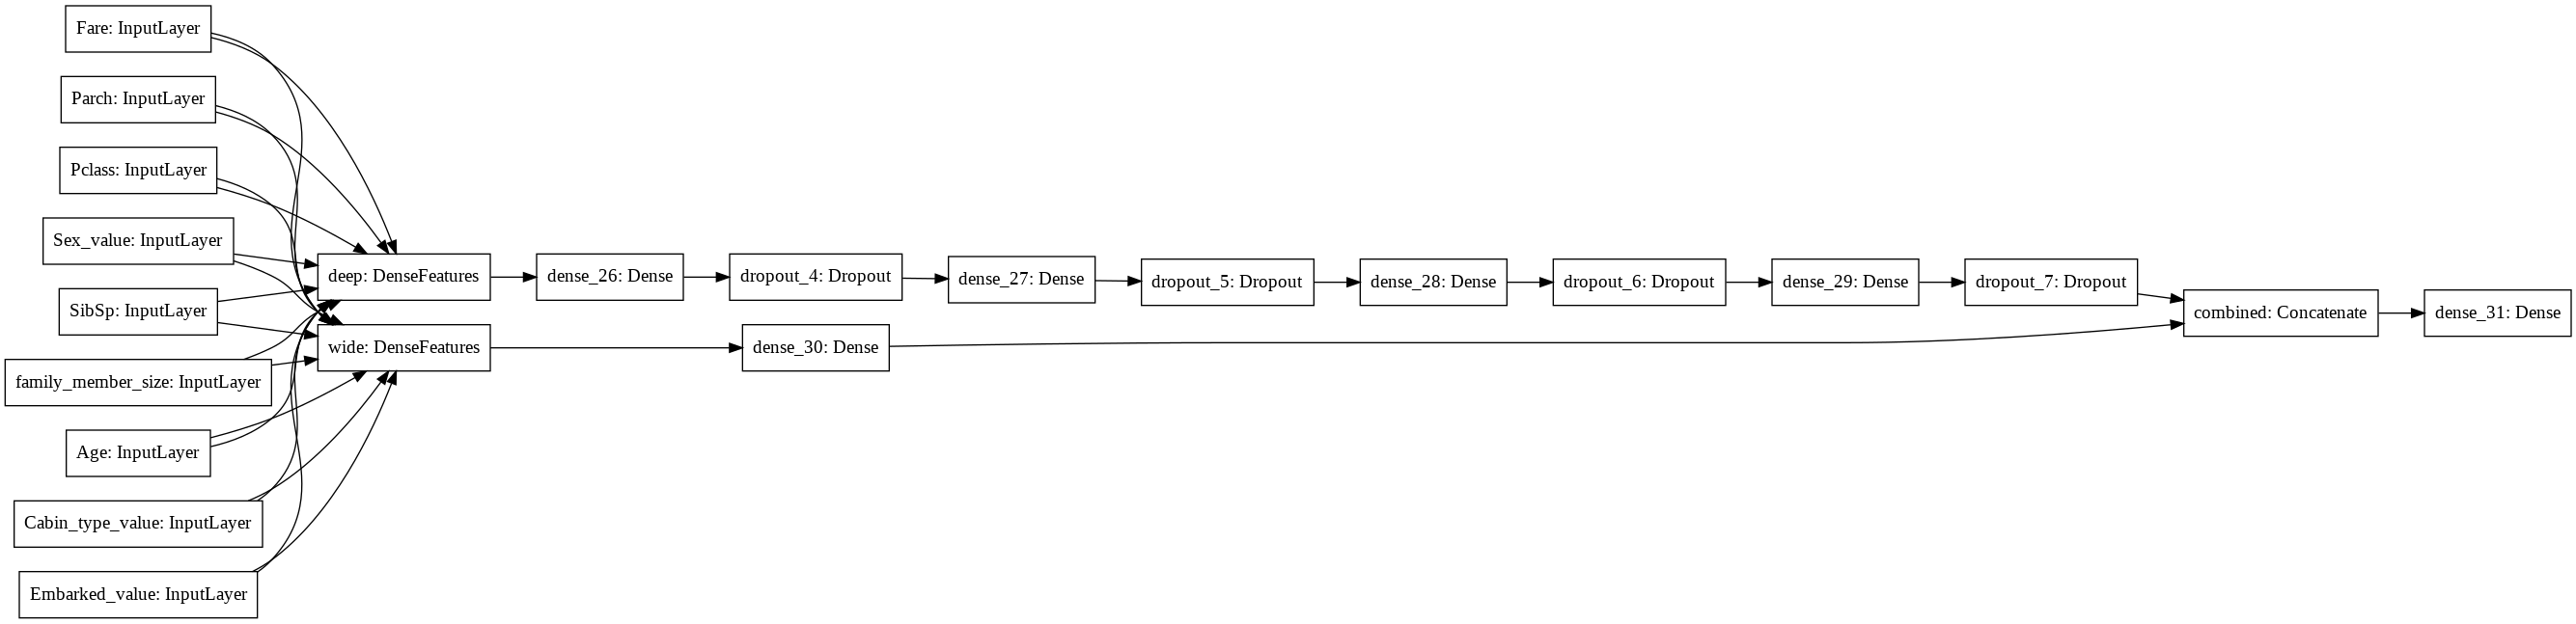

In [209]:
deep_and_wide_model = build_deep_and_wide_model()
tf.keras.utils.plot_model(deep_and_wide_model, show_shapes=False, rankdir='LR')

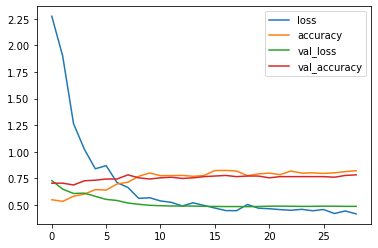

In [210]:
epochs = 400
early_stop = tf.keras.callbacks.EarlyStopping(patience=10)
steps_per_epoch = train_data.shape[0] // batch_size
history = deep_and_wide_model.fit(
    train_dataset, 
    steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=[early_stop],
    verbose=0
)
pd.DataFrame(history.history).plot()

In [211]:
# y_pred =  np.array(deep_and_wide_model.predict(val_dataset) > 0.5, dtype=int).reshape(-1)
y_pred = np.array(deep_and_wide_model.predict(val_dataset)>0.5,dtype=int).reshape(-1)
score = accuracy_score(val_data["Survived"], y_pred)
print("Accuraccy Score: ",score)
print(sklearn.metrics.classification_report(val_data["Survived"], y_pred))
Survived = np.argmax(deep_and_wide_model.predict(test_dataset), axis=-1).reshape(-1)
# print(np.argmax(deep_and_wide_model.predict(test_dataset),axis=1).reshape(-1))
# print(test.shape)
print(Survived.shape)
Models['deep_and_wide_model']=[deep_and_wide_model,score]

Accuraccy Score:  0.5698324022346368
              precision    recall  f1-score   support

         0.0       0.65      0.75      0.70       118
         1.0       0.31      0.21      0.25        61

    accuracy                           0.57       179
   macro avg       0.48      0.48      0.48       179
weighted avg       0.53      0.57      0.55       179

(418,)


## Other Models

### Make Datasets

In [212]:
EN_train.corr()["Survived"].sort_values(key=lambda x: abs(x), ascending=False)

Survived                    1.000000
Sex_value                  -0.543351
Pclass                     -0.338481
Cabin_type_value           -0.301116
Fare                        0.257307
Embarked_value             -0.167675
family_member_type_value   -0.108631
Parch                       0.081629
Age                        -0.070323
Title_value                -0.062139
SibSp                      -0.035322
family_member_size          0.016639
Name: Survived, dtype: float64

In [213]:
EN_train.corr()["Survived"].sort_values(key=lambda x: abs(x), ascending=False)

Survived                    1.000000
Sex_value                  -0.543351
Pclass                     -0.338481
Cabin_type_value           -0.301116
Fare                        0.257307
Embarked_value             -0.167675
family_member_type_value   -0.108631
Parch                       0.081629
Age                        -0.070323
Title_value                -0.062139
SibSp                      -0.035322
family_member_size          0.016639
Name: Survived, dtype: float64

In [214]:
LT = list(EN_train.corr()[EN_train.corr()["Survived"].abs() > 0.2].index) 
LT1 = list(OH_train.corr()[OH_train.corr()["Survived"].abs() > 0.2].index) 
dataset0 = EN_train[LT]
#print(dataset0)
dataset1 = OH_train[LT1]
dataset2 = copy.copy(OH_train)
dataset3 = copy.copy(EN_train)
LT.remove("Survived")
LT1.remove("Survived")
testset0 = EN_test[LT]
testset1 = OH_test[LT1]
testset2 =  copy.copy(OH_test)
testset3 = copy.copy(EN_test)

In [215]:
dataset0

,Survived,Pclass,Fare,Sex_value,Cabin_type_value
0,0.0,1.0,0.014151,1.0,1.000
1,1.0,0.0,0.139136,0.0,0.250
2,1.0,1.0,0.015469,0.0,1.000
3,1.0,0.0,0.103644,0.0,0.250
4,0.0,1.0,0.015713,1.0,1.000
...,...,...,...,...,...
886,0.0,0.5,0.025374,1.0,1.000
887,1.0,0.0,0.058556,0.0,0.125
888,0.0,1.0,0.045771,0.0,1.000
889,1.0,0.0,0.058556,1.0,0.250


### Dict set up

In [216]:
def model_name(name):
  if name == 'sgd':
    name = "Stochastic Gradient Descent"
    return name
  elif name == 'lr':
    name = "Logistic Regression"
    return name 
  elif name == 'svm':
    name = "Support Vector Classification"
    return name 
  elif name == 'knn':
    name = "K Nearest Neighbors Classification"
    return name 
  elif name == 'gpc':
    name = "Gaussian Process Classifier"
    return name 
  elif name == 'dtc':
    name = "Decision Tree Classifier"
    return name
  elif name == 'abc':
    name = "AdaBoost Classifier"
    return name
  elif name == 'rfc':
    name = "Random Forest Classifier"
    return name
  elif name == 'gbc':
    name = "Gradient Boosting Classifier"
    return name
  elif name == 0:
    name = "EN cor dataset"
    return name 
  elif name == 1:
    name = "OH cor dataset"
    return name 
  elif name == 2:
    name = "OH dataset"
    return name 
  elif name == 3:
    name = "EN dataset"
    return name
  else:
    return name
  return name

# "EN cor dataset"
# "OH cor dataset"
# "OH dataset"
# "EN dataset"


In [217]:
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process.kernels import RationalQuadratic, Exponentiation, RBF
import time
from sklearn.model_selection import RandomizedSearchCV
import warnings
warnings.filterwarnings("ignore")

# Models
sgd = SGDClassifier(random_state = 42)
lr = LogisticRegression(random_state = 42)
svm = SVC(random_state = 42)
knn = KNeighborsClassifier()
gpc = GaussianProcessClassifier(random_state = 42)
dtc = DecisionTreeClassifier(random_state = 42)
abc = AdaBoostClassifier(random_state = 42)
rfc = RandomForestClassifier(random_state = 42)
gbc = GradientBoostingClassifier(random_state = 42)
# Model Dict
models = dict(sgd = sgd, 
              lr = lr, 
              svm = svm, 
              knn= knn, 
              gpc = gpc, 
              dtc = dtc, 
              abc =abc, 
              rfc = rfc,
              gbc = gbc)
# Parameters
params = {
    
    'sgd':dict(learning_rate = ['adaptive', 'optimal', 'constant', 'invscaling'],
               eta0 = list(np.arange(0.001, 0.15, 0.001)),
               max_iter = list(np.arange(1000.0,10000.0,10.0)),
               random_state= [42],
               early_stopping =[True]),
    'lr':dict(solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
              C = list(np.arange(1,20)),
              max_iter = list(np.arange(100,1000,10))
              ),
    'svm':dict(kernel=['linear', 'poly', 'rbf', 'sigmoid'],
               gamma = ['scale', 'auto'],
               max_iter = [-1]),
    'knn':dict(n_neighbors = list(np.arange(5,50,5)),
               algorithm = ['auto', 'ball_tree', 'kd_tree', 'brute'],
               leaf_size = list(np.arange(30,100, 10))
               ),
    'gpc':dict(#kernel = [(1.0 * RBF(1.0)), RationalQuadratic(length_scale=1.0, alpha=1.5)], #Exponentiation(RationalQuadratic(), exponent=2), Exponentiation(RBF(), exponent=2)],
              max_iter_predict = list(np.arange(100,1000,10))
               ),
    'dtc':dict(criterion = ['gini', 'entropy'],
               max_depth = [None]+list(np.arange(10,100,10)),
               min_samples_split = list(np.arange(2,10,2)),
               min_samples_leaf =  list(np.arange(1,10)),
               max_features = ['auto', 'sqrt', 'log2'] ,
               max_leaf_nodes = [None]+list(np.arange(100,1000,10))       
               ),
    'abc':dict(n_estimators = list(np.arange(50,100,10)),
              learning_rate = list(np.arange(1,20,1)),
              algorithm = ['SAMME', 'SAMME.R']             
               ),
    'rfc':dict(n_estimators = list(np.arange(100,500,10)),
              criterion = ['gini', 'entropy'],
              max_depth = [None]+list(np.arange(10,100,10)),
              min_samples_split = list(np.arange(2,10,2)),
              min_samples_leaf =  list(np.arange(1,10)),
              max_features = ['auto', 'sqrt', 'log2'] ,
              max_leaf_nodes = [None]+list(np.arange(100,1000,10))        
               ),
    'gbc':dict(loss=['deviance', 'exponential'],
               learning_rate = list(np.arange(0.05,0.5,0.05, dtype = float)),
               n_estimators = list(np.arange(100,500,10)),
               criterion=['friedman_mse', 'mse', 'mae'],
               min_samples_split = list(np.arange(2,10,2)),
               min_samples_leaf =  list(np.arange(1,10)),
               max_depth = list(np.arange(3,50,1)),
               max_features = ['auto', 'sqrt', 'log2'],
               max_leaf_nodes = [None]+list(np.arange(100,1000,10)),
               n_iter_no_change =[None]+list(np.arange(3,10,1)) 
               )
}
# Best Accuracy for each model may have different data 
# best_models format [model, accuracy, dataset name]
best_models=dict(sgd = [sgd,0,0], 
              lr = [lr,0,0], 
              svm = [svm,0,0], 
              knn= [knn,0,0], 
              gpc = [gpc,0,0], 
              dtc = [dtc,0,0], 
              abc =[abc,0,0], 
              rfc = [rfc,0,0],
              gbc = [gbc,0,0])
local_model = {
    'Data Set':[],
    'Best Model':[],
    'Accuracy':[]
}
datasets = {
  "EN cor dataset":dataset0,
  "OH cor dataset":dataset1,
  "OH dataset":dataset2, 
  "EN dataset":dataset3
}
testsets = {
  "EN cor dataset":testset0,
  "OH cor dataset":testset1,
  "OH dataset":testset2, 
  "EN dataset":testset3
}


### Find Best Models


In [218]:
dataset1.shape

(891, 11)

In [219]:
isValUsed = True

In [221]:
best_score = 0
best_model_name = ""
best_dataset = ''
count = 0
print(isValUsed)
# best_models format [model, accuracy, dataset name]
for data in datasets.keys():
  X_train, X_val, X_test, y_train, y_val, y_test = get_train_test(datasets[data], False, isValUsed)
  temp_best_score = 0
  temp_best_model = ''
  print("Dataset:",data)
  print("\n{:^40}|   {:^40}| {:^40}".format("Model", "Accuracy", "Time"))
  startDst = time.time() # dataset time
  for model in models.keys():
    
    startLocal = time.time() # model time
    random = RandomizedSearchCV(models[model], params[model],
                                n_iter=100, scoring='accuracy', n_jobs=-1, 
                                cv=3, verbose=0, random_state=42)
    # Fit Model
    random.fit(X_train, y_train)
    # try diff type acc
    if isValUsed:
      predFit = random.predict(X_test)
      predAcc = accuracy_score(predFit,y_test)
      #print(accuracy_score(predFit,y_test))
    else:
      predFit = random.predict(X_val)
      predAcc = accuracy_score(predFit,y_val)
      #print(accuracy_score(predFit,y_val))

    # Check to see if best model for the model type
    # best_models format [model, accuracy, model name]
    # predAcc = random.best_score_
    if best_models[model][1] < predAcc:
      # best_models[model] = [random.best_estimator_, random.best_score_, data]
      best_models[model] = [random.best_estimator_, predAcc, data]
    endLocal = time.time()-startLocal
    # Display Each model score
    print("{:<40}|   {:<40.4f}|  {:<40.4f}".format(model_name(model), predAcc, endLocal))
    # local max accuracy
    if predAcc > temp_best_score:
       temp_best_score = predAcc
       temp_best_model = model_name(model)
    # Total max accuracy
    if predAcc > best_score:
      best_score = predAcc
      best_model_name = model_name(model)
      best_dataset = data
  # Exited For Loop
  # local best accuracy score and model
  endDst = time.time()-startDst
  print("\nBest Score: %f \nBest Model: %s \nDataset: %s\nDataset Time: %.4f \n\n"
    %(temp_best_score, temp_best_model, data, endDst))
  count+=1
# Exited For Loop
print("Total Best Score:",best_score,"\nBest Model:",best_model_name, "\nBest dataset:", best_dataset)

True
Dataset: EN cor dataset

                 Model                  |                   Accuracy                |                   Time                  
Stochastic Gradient Descent             |   0.7222                                  |  3.4866                                  
Logistic Regression                     |   0.7222                                  |  1.7378                                  
Support Vector Classification           |   0.7222                                  |  0.2303                                  
K Nearest Neighbors Classification      |   0.7444                                  |  3.3460                                  
Gaussian Process Classifier             |   0.7222                                  |  16.6654                                 
Decision Tree Classifier                |   0.8111                                  |  1.0397                                  
AdaBoost Classifier                     |   0.7222                         

### Make Pred for Voting

In [105]:
from sklearn.metrics import accuracy_score
# Try variable majority voting 
#################################################
if isValUsed:
  maj = np.zeros(90)
  maj1 = np.zeros(90)
else: 
  maj = np.zeros(180)
  maj1 = np.zeros(180)
  

In [106]:
# best_model Format [model, accuracy, dataset name]
# for sklearn
for x in best_models.keys():
  dataset_name = best_models[x][2]
  X_train, X_val, X_test, y_train, y_val, y_test = get_train_test(datasets[dataset_name], False, isValUsed)
  model=best_models[x][0].fit(X_train,y_train)
  if isValUsed:
    print("Model Name:",x,"\nAccuracy:", accuracy_score(y_test, model.predict(X_test)))
    maj+=model.predict(X_test)
  else:
    print("Model Name:",x,"\nAccuracy:", accuracy_score(y_val, model.predict(X_val)))
    maj+= model.predict(X_val)


Model Name: sgd 
Accuracy: 0.8111111111111111
Model Name: lr 
Accuracy: 0.8111111111111111
Model Name: svm 
Accuracy: 0.7888888888888889
Model Name: knn 
Accuracy: 0.7777777777777778
Model Name: gpc 
Accuracy: 0.7888888888888889
Model Name: dtc 
Accuracy: 0.8111111111111111
Model Name: abc 
Accuracy: 0.8
Model Name: rfc 
Accuracy: 0.7888888888888889
Model Name: gbc 
Accuracy: 0.8222222222222222


In [107]:
# for NNs
for i in datasets.keys():
  data = datasets[i]
  if "cor"  not in i:
    X_train, X_val, X_test, y_train, y_val, y_test = get_train_test(data, True, isValUsed)
    model = get_trained_CNN_model(data, isValUsed)
    if isValUsed:
      y_pred = np.array(model.predict(X_test)>0.4,dtype=int).reshape(-1)
      print("Model Name: CNN","\nDataset:",i, "\nAccuracy:", accuracy_score(y_test, y_pred))
      maj1+= y_pred
    else:
      y_pred = np.array(model.predict(X_Val)>0.4,dtype=int).reshape(-1)
      print("Model Name: CNN","\nDataset:",i, "\nAccuracy:", accuracy_score(y_val, y_pred))
      maj1+= y_pred
  # DNN
  X_train, X_val, X_test, y_train, y_val, y_test = get_train_test(data, False, isValUsed)
  model = get_trained_DNN_model(data, isValUsed)
  if isValUsed:
    y_pred = np.array(model.predict(X_test)>0.4,dtype=int).reshape(-1)
    print("Model Name: DNN","\nDataset:",i, "\nAccuracy:", accuracy_score(y_test, y_pred))
    maj1+= y_pred
  else:
    y_pred = np.array(model.predict(X_Val)>0.4,dtype=int).reshape(-1)
    print("Model Name: DNN","\nDataset:",i, "\nAccuracy:", accuracy_score(y_val, y_pred))
    maj1+= y_pred

Model Name: DNN 
Dataset: EN cor dataset 
Accuracy: 0.7222222222222222
Model Name: DNN 
Dataset: OH cor dataset 
Accuracy: 0.7777777777777778
Model Name: CNN 
Dataset: OH dataset 
Accuracy: 0.8
Model Name: DNN 
Dataset: OH dataset 
Accuracy: 0.7888888888888889
Model Name: CNN 
Dataset: EN dataset 
Accuracy: 0.8
Model Name: DNN 
Dataset: EN dataset 
Accuracy: 0.7666666666666667


#### Print Best Model Combination

In [108]:
NN_pred = copy.copy(maj1)
sk_pred = copy.copy(maj)
pred_com = maj1+maj 
def print_best_acc(pred, num_stop, test_ans):
  local_acc = 0
  acc = 0
  num = 0
  print("\n{:^20}|{:^20}".format("Number of Correct", "Accuracy"))
  for i in range(1,num_stop):
    pred_arry = copy.copy(pred)
    for x in range(len(pred_arry)):
      if pred_arry[x] >= i:
        pred_arry[x] = 1
      else:
        pred_arry[x] = 0
    local_acc = accuracy_score(test_ans,pred_arry)
    print("{:^20}|  {:<20.4f}".format(">= "+str(i), local_acc))
    if local_acc > acc:
      num = i
      acc = local_acc
  print("Best Found Number: ")
  print("{:^20}|  {:<20.4f}".format(">= "+str(num), acc ))

### Apply Function

#### Maj Voting ?

In [109]:
NN_pred = copy.copy(maj)
sk_pred = copy.copy(maj1)
pred_com = NN_pred + sk_pred
if isValUsed:
  predicted = y_test
else:
  predicted = y_val
print("Sklearn")
print_best_acc(sk_pred, 9, predicted)
print("NNs")
print_best_acc(NN_pred, 6, predicted)
print("Combined")
print_best_acc(pred_com, 15, predicted)

Sklearn

 Number of Correct  |      Accuracy      
        >= 1        |  0.7778              
        >= 2        |  0.8000              
        >= 3        |  0.8000              
        >= 4        |  0.7667              
        >= 5        |  0.7778              
        >= 6        |  0.7333              
        >= 7        |  0.6222              
        >= 8        |  0.6222              
Best Found Number: 
        >= 2        |  0.8000              
NNs

 Number of Correct  |      Accuracy      
        >= 1        |  0.8333              
        >= 2        |  0.8222              
        >= 3        |  0.8222              
        >= 4        |  0.8222              
        >= 5        |  0.8111              
Best Found Number: 
        >= 1        |  0.8333              
Combined

 Number of Correct  |      Accuracy      
        >= 1        |  0.7667              
        >= 2        |  0.8111              
        >= 3        |  0.8222              
        >= 4      

### Determine Percent

In [110]:
# cop = np.zeros(179)
# #print("{:^20}| {:^20}| {:^20}| {:^20}".format("Data Set", "DNN Type","Percent", "Accuracy"))
# temp = 0
# acc = 0
# per = 0
# for i in datasets.keys():
#   print("{:^20}| {:^20}| {:^20}| {:^20}".format("Data Set", "DNN Type","Percent", "Accuracy"))
#   data = datasets[i]
#   #print(i)
#   temp = 0
#   acc = 0
#   per = 0

#   if "cor"  not in i:
#     for j in np.linspace(.1, 1, num=10):
#       #print("CNN:")
#       X_train, X_val, X_test, y_train, y_val, y_test = get_train_test(data, True, isValUsed)
#       model = get_trained_CNN_model(data, isValUsed)
#       y_pred = np.array(model.predict(X_test)>round(j,1),dtype=int).reshape(-1)
#       temp_acc = accuracy_score(y_test,y_pred)
#       print("{:<20}| {:<20}| {:<20}| {:<20.4f}".format(i, "CNN",round(j,1), accuracy_score(y_test,y_pred))) # for debug
#       if temp_acc > acc:
#         acc = temp_acc
#         per = round(j,1) 
#     print("Best CNN: ")
#     print("{:<20}| {:<20}| {:<20}| {:<20.4f}\n".format(i, "CNN", per, acc))
#     print("{:^20}| {:^20}| {:^20}| {:^20}".format("Data Set", "DNN Type","Percent", "Accuracy"))
#   temp = 0
#   acc = 0
#   per = 0
#   for j in np.linspace(.1, 1, num=10):
#     X_train, X_val, X_test, y_train, y_val, y_test = get_train_test(data, False, isValUsed)
#     model = get_trained_DNN_model(data, isValUsed)
#     y_pred = np.array(model.predict(X_test)>round(j,1),dtype=int).reshape(-1)
#     temp_acc = accuracy_score(y_test,y_pred)
#     print("{:<20}| {:<20}| {:<20}| {:<20.4f}".format(i, "DNN", round(j,1),accuracy_score(y_test,y_pred))) #debug
#     if temp_acc > acc:
#         acc = temp_acc
#         per = round(j,1) 
#   print("Best DNN: ")      
#   print("{:<20}| {:<20}| {:<20}| {:<20.4f}\n".format(i, "DNN", per,acc))
    
#print(cop)

### Stacking 

In [111]:
# model = DNN_model(X_train.shape[1])
# model._estimator_type = "classifier"

In [246]:
from sklearn.ensemble import StackingClassifier
isValUsed = False
X_train, X_val, X_test, y_train, y_val, y_test = get_train_test(OH_train, False, isValUsed)

stackModelEstimators = []
for x in best_models.items():
  i,j = x
  k = (i,j[0])
  stackModelEstimators.append(k)
clf = StackingClassifier(
estimators=stackModelEstimators, verbose = 0, cv =5, n_jobs=-1)
for i in datasets.keys():
  data = datasets[i]
  X_train, X_val, X_test, y_train, y_val, y_test = get_train_test(data, False, isValUsed)
  clf.fit(X_train, y_train)
  if isValUsed:
    print("Dataset:",i,"\nAccuracy",round(clf.score(X_test, y_test),3))
  else:
    print("Dataset:",i,"\nAccuracy",round(clf.score(X_val, y_val),3))

Dataset: EN cor dataset 
Accuracy 0.821
Dataset: OH cor dataset 
Accuracy 0.832
Dataset: OH dataset 
Accuracy 0.821
Dataset: EN dataset 
Accuracy 0.81


```
# For isValUsed = True
Dataset: EN cor dataset 
Accuracy 0.8222222222222222
Dataset: OH cor dataset 
Accuracy 0.8222222222222222
Dataset: OH dataset 
Accuracy 0.7888888888888889
Dataset: EN dataset 
Accuracy 0.7666666666666667


# For isValUsed = False
Dataset: EN cor dataset 
Accuracy 0.8212290502793296
Dataset: OH cor dataset 
Accuracy 0.8324022346368715
Dataset: OH dataset 
Accuracy 0.8212290502793296
Dataset: EN dataset 
Accuracy 0.8100558659217877
```



# Testing
Note: this is very messy and me experimenting with things

In [113]:
#train1.info()
# df = train1.infer_objects()
# df['Age'].dtype.char
# df['Cabin'].dtype.char
# train1['Sex'] = train1['Sex'].astype('category')
# print(df['Cabin'].dtype.char)
# print(train1['Sex'].dtype)
# if df['Sex'].dtype == 'Object':
#   print("true")
# print(df['Sex'].dtype)
# if df['Cabin'].dtype == 'Object':
#   print("true")

## Working DNN stack ensemble
Note: Adding DNN does not improve accuracy

In [222]:
def DNN_model():
  model = tf.keras.Sequential([
      tf.keras.layers.Input(shape=(X_train.shape[1])),
      tf.keras.layers.Dense(1000, activation='relu', name = "L1"), 
      tf.keras.layers.Dense(750, activation='relu', name = "L2"),  
      tf.keras.layers.Dense(500, activation='relu', name = "L3"),  
      tf.keras.layers.Dense(250, activation='relu', name = "L4"),  
      tf.keras.layers.Dense(50, activation='relu', name ="L5"),
      tf.keras.layers.Dense(1, activation='sigmoid', name ="L6")                          
  ])
  model.NAME = "model1"
  model._estimator_type = "classifier" # debug for stackin
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  return model

In [242]:
# datasets = {
#   "EN cor dataset":dataset0,
#   "OH cor dataset":dataset1,
#   "OH dataset":dataset2, 
#   "EN dataset":dataset3
# }


# ####################################
# works for DNN not CNN
######################################
isValUsed = False
isCC = False
import warnings
warnings.filterwarnings("ignore")
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
X_train, X_val, X_test, y_train, y_val, y_test = get_train_test(dataset1, isCC, isValUsed)
if isCC:
  x, y, z = X_train.shape
  inputDim = (y,z)
else:
  inputDim = X_train.shape
stackModelEstimators = []
for x in best_models.items():
  i,j = x
  k = (i,j[0])
  stackModelEstimators.append(k)
#model = DNN_model(inputDim)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='accuracy',patience=10)
model1 = KerasClassifier(
    build_fn=lambda: DNN_model(), epochs = 20, verbose = 0, callbacks= [early_stop])
model1._estimator_type = "classifier"
#stackModelEstimators.append(('dn',model1))
clf = StackingClassifier(
estimators=stackModelEstimators, verbose = 0, cv =5)
clf.fit(X_train, y_train)
pred1 = clf.predict(X_val)
print("score without DNN:",clf.score(X_val,y_val))
stackModelEstimators.append(('dn',model1))
clf1 = StackingClassifier(
estimators=stackModelEstimators, verbose = 0, cv =5)
clf1.fit(X_train, y_train)
print("Score with DNN:",clf1.score(X_val,y_val))

score without DNN: 0.8324022346368715
Score with DNN: 0.8324022346368715


## Model test

In [238]:
# CNN does not stack
# tf.keras.layers.Conv1D(128, 2, activation='relu',input_shape=input_shape),
#   tf.keras.layers.MaxPooling1D(pool_size=2),
#   tf.keras.layers.Conv1D(128, 4, activation='relu'),
#   tf.keras.layers.MaxPooling1D(pool_size=2),
#   tf.keras.layers.Flatten(),
#   tf.keras.layers.Dense(100, activation="relu"),
#   tf.keras.layers.Dense(1, activation='sigmoid')
# isValUsed = True
# isCC = True
# X_train, X_val, X_test, y_train, y_val, y_test = get_train_test(dataset1, isCC, isValUsed)
import itertools

# alist = ['dog', 'cat', 'fish']
# for result in itertools.combinations(alist, 2):
#     print(list(result))


502


## Stacking Combo Fun!
Note: 502 unordered combinations

In [ ]:
import itertools
names =[]
for best in best_models.keys():
  names.append(best)
comb=[]
for i in range(2,len(names)+1):
  for j in itertools.combinations(names, i):
    j = list(j)
    comb.append(j)
print(len(comb))

In [241]:
ct = []
for i in comb: # for every combination
  temp = []
  for j in i:
    temp.append((j,best_models[j]))
  ct.append(temp)

In [249]:
# on hold until I can make parrallel function
import datetime
X_train, X_val, X_test, y_train, y_val, y_test = get_train_test(dataset1, isCC, isValUsed)
best_acc = 0
bestModel = best_models['dtc']
count = 0
for i in ct:
  start = time.time()
  clf = StackingClassifier(
  estimators=stackModelEstimators, verbose = 0, cv =5, n_jobs=-1)
  clf.fit(X_train, y_train)
  acc = clf.score(X_val,y_val)
  end = time.time()-start
  print("Combo #"+str(count)+"\nTime taken: "+ str(datetime.timedelta(seconds = round(end)))+"\n")
  count+=1
  if acc > best_acc:
    best_acc = acc 
    best_model = clf
print("Best Score:",best_acc)


Combo #0
Time taken: 0:00:05

Combo #1
Time taken: 0:00:04

Combo #2
Time taken: 0:00:04

Combo #3
Time taken: 0:00:04

Combo #4
Time taken: 0:00:03

Combo #5
Time taken: 0:00:03

Combo #6
Time taken: 0:00:04

Combo #7
Time taken: 0:00:03

Combo #8
Time taken: 0:00:04

Combo #9
Time taken: 0:00:04

Combo #10
Time taken: 0:00:04

Combo #11
Time taken: 0:00:04

Combo #12
Time taken: 0:00:04

Combo #13
Time taken: 0:00:04

Combo #14
Time taken: 0:00:04

Combo #15
Time taken: 0:00:04

Combo #16
Time taken: 0:00:04

Combo #17
Time taken: 0:00:03

Combo #18
Time taken: 0:00:04

Combo #19
Time taken: 0:00:04

Combo #20
Time taken: 0:00:04

Combo #21
Time taken: 0:00:04

Combo #22
Time taken: 0:00:04

Combo #23
Time taken: 0:00:03

Combo #24
Time taken: 0:00:04

Combo #25
Time taken: 0:00:03

Combo #26
Time taken: 0:00:04

Combo #27
Time taken: 0:00:04

Combo #28
Time taken: 0:00:04

Combo #29
Time taken: 0:00:04



KeyboardInterrupt: ignored